## Задание 5.2

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 

Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

Ваша задача — проанализировать данные АB-теста./

Выбрать метод анализа и сравнить CTR в двух группах.
Сравните данные тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.

In [1]:
# импортируем необходимые библиотеки

import pandas as pd
#import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np

In [2]:
# Подключение БД

connection = {'host': 'https://clickhouse.lab.karpov.courses',
'password': 'dpo_python_2020',
'user': 'student',
'database': 'simulator'
}

# SQL Запрос на получение необходимых данных из БД

query = '''
SELECT 
  exp_group,
  user_id,
  COUNT(action) FILTER (WHERE action = 'like') AS "likes",
  COUNT(action) FILTER (WHERE action = 'view') AS "views",
  COUNT(action) FILTER (WHERE action = 'like') / 
  COUNT(action) FILTER (WHERE action = 'view') AS "CTR"
FROM 
  simulator_20230120.feed_actions
WHERE 
  exp_group IN (2, 1)
  AND DATE(time) BETWEEN '2023-01-01' AND '2023-01-07'
GROUP BY 
  exp_group,
  user_id
'''

In [3]:
df = pandahouse.read_clickhouse(query=query, connection=connection)

In [2]:
df = pd.read_csv('data_for_AB_test.csv')

In [4]:
print(df.info())
df.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20031 entries, 0 to 20030
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   exp_group  20031 non-null  int64  
 1   user_id    20031 non-null  int64  
 2   likes      20031 non-null  int64  
 3   views      20031 non-null  int64  
 4   CTR        20031 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 782.6 KB
None


,exp_group,user_id,likes,views,CTR
0,1,109963,3,15,0.2


In [5]:
df.exp_group.value_counts()

1    10079
2     9952
Name: exp_group, dtype: int64

##### Данные содержат следующие столбцы:
- номер тестовой группы пользователя (exp_group);
- Id пользователя (user_id);
- Кол-во лайков пользователя (likes);
- Кол-во просмотренных постов пользователем (views);
- Соотношение кол-ва лайков на просмотренные посты (CTR).

In [6]:
df.CTR[df.exp_group == 1].describe()

count    10079.000000
mean         0.215605
std          0.084160
min          0.000000
25%          0.160097
50%          0.203125
75%          0.257654
max          0.722222
Name: CTR, dtype: float64

In [7]:
df.CTR[df.exp_group == 2].describe()

count    9952.000000
mean        0.214419
std         0.144180
min         0.000000
25%         0.095238
50%         0.142857
75%         0.325000
max         0.923077
Name: CTR, dtype: float64

Исходя из описательной статистики видно, что метрика в группе 2 имеет большую изменчивость. О чем может свидетельствовать высокое среднеквадратическое отклонение относительно средней велечины, большая разница между средним и медианным значением, можно предположить что распределение значений в выборке имеет значительный скос в правую сторону, что и повлекло за собой увеличение средней величины и среднеквадратического отклонения. 

In [17]:
print(f'Коэффициент ассиметрии выборки CTR, 2 группа = {stats.skew(df.CTR[df.exp_group == 2], bias=False)};\n\
Коэффициент ассиметрии выборки CTR, 1 группа = {stats.skew(df.CTR[df.exp_group == 1], bias=False)}.')

Коэффициент ассиметрии выборки CTR, 2 группа = 0.8346301249835315;
Коэффициент ассиметрии выборки CTR, 1 группа = 1.0177755544972011.


Рассчитанный коэф. ассиметрии для обоих выборок, подтверждает, что выборки имеют значительный скос в правую сторону.
    
Также выполним тест Шапиро-Уилка, чтобы точно понять распределены ли наши значения в выборках согласно нормальному распределению или нет.

In [20]:
st, pvalue = stats.shapiro(df.CTR[df.exp_group == 2])
st1, pvalue1 = stats.shapiro(df.CTR[df.exp_group == 1])
print(f'Тест Шапиро-Уилки тестовая группа p-value - {pvalue};\n\
Тест Шапиро-Уилки тестовая группа p-value - {pvalue1}.')

Тест Шапиро-Уилки тестовая группа p-value - 0.0;
Тест Шапиро-Уилки тестовая группа p-value - 0.0.


p-value в обоих случаях меньше α = 0,05, что дает нам право отклонить нулевую гипотезу о нормальности распределение в обоих выборках.

Посмотрим на распределения на графике.

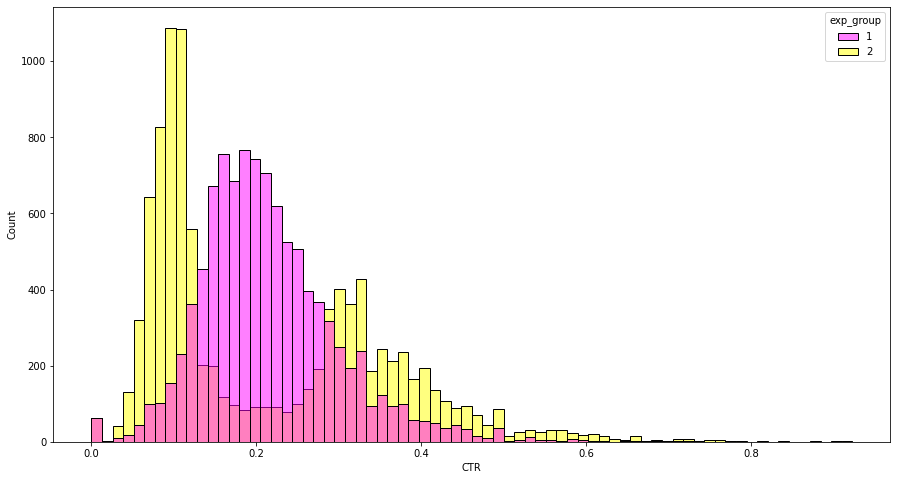

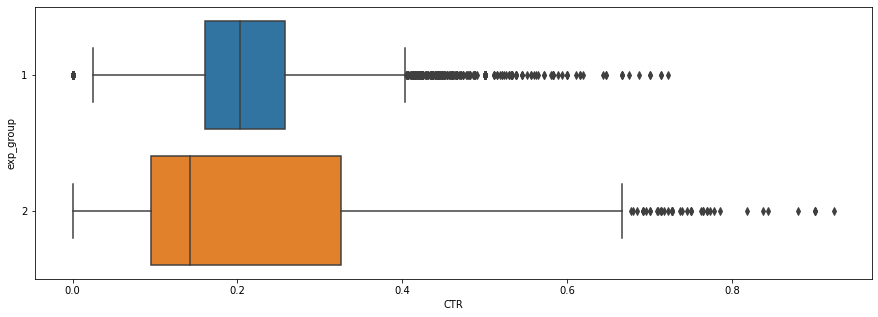

In [21]:
# Построим boxplot и гистограмму распределния интересущей нас метрики "CTR" с разделением на тестовые группы, чтобы визуально сравнить две выборки.

plt.figure(figsize=(15, 8))
sns.histplot(x=df.CTR, hue=df.exp_group, palette='spring')
plt.show()

plt.figure(figsize=(15, 5))
sns.boxplot(x=df.CTR, y=df.exp_group, orient='h')
plt.show()

При визуальном анализе распределения CTR в группе 2 видим большую вариативность. Выборка не является однородной, можно сказать что пользователи в тестовой группе разделились на 2 лагеря, у большего количества пользователей CTR значительно меньше, чем у контрольной группы, тогда как у оставшихся пользователей 2 группы CTR вырос.
В данном случае, учитывая, что распределения в выборках не является нормальным, наблюдается скос распределения вправую сторону, видны значительные выборосы в обоих выборках, а распределение в тестовой группе скорее напоминает две выборки, чем одну, использовать для сравнения t-критерий не целесообразно, результаты будут не корректны. КОрректней будет использовать тест Манна-Уитни.
    
Так как CTR это относительная величина, следует посмотреть на пользователей в тестовой группе у которых оказалось мало просмотров и при этом они имеют очень низкий или высокий CTR, если таких пользователей много, то это и могло повлиять на существенное разделение выборки на 2 лагеря. Если это действительно так, то в данном случае нам может помочь сглаживание CTR. Также не лишним будет взглянуть на общее распределения количества просмотров постов по группам.

In [22]:
print(f'Всего пользователей в тестовой группе, у которых меньше 10 просмотренных постов за анализируемый период - \
{len(df[(df.views < 10) & (df.exp_group == 2)])}.\n\
Пользователей, у которых меньше 10 просмотров и CTR меньше 0,2 - \
{len(df[(df.views < 10) & (df.exp_group == 2) & (df.CTR < 0.2)])}.\n\
Пользователей, у которых меньше 10 просмотров и CTR больше 0,2 - \
{len(df[(df.views < 10) & (df.exp_group == 2) & (df.CTR > 0.2)])}.')

Всего пользователей в тестовой группе, у которых меньше 10 просмотренных постов за анализируемый период - 136.
Пользователей, у которых меньше 10 просмотров и CTR меньше 0,2 - 48.
Пользователей, у которых меньше 10 просмотров и CTR больше 0,2 - 86.


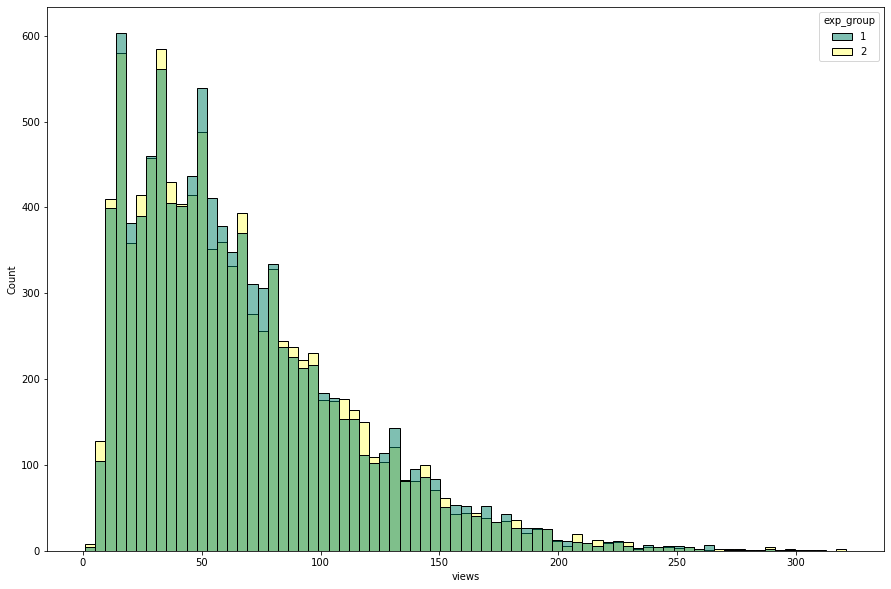

In [23]:
# Построим гисторграмму распределения просмотров.

plt.figure(figsize=(15, 10))
sns.histplot(x=df.views, hue=df.exp_group, palette='summer')
plt.show()

In [24]:
print(stats.ttest_ind(df.views[df.exp_group == 1], df.views[df.exp_group == 2], equal_var=False))
stats.mannwhitneyu(df.views[df.exp_group == 1], df.views[df.exp_group == 2])

Ttest_indResult(statistic=0.23743803558240428, pvalue=0.8123194142018666)


MannwhitneyuResult(statistic=50312084.5, pvalue=0.6976248926750942)

В целом распределение кол-ва просмотров по группам схожи, что видно из графика. Также полученные результаты t-критерия и теста Манна-Уитни не дают нам оснований для отвержения нулевой гипотезы о неравенстве выборок, p-value в обоих тестах значительно выше значения α.

Количество пользователей с просмотрами меньше 10 постов и которые могли бы существенно повлиять на полученные результаты CTR в выборке не велико, а следовательно при сглаживании CTR мы существенно картину распределения не поменяем.

Итак для сравнения CTR в группах мы будем использовать тест Манна-Уитни и Пуассоновский бутстреп для сравнения разниц общегруппового CTR. Хотя уже на данном этапе можно сказать, что новый алгоритм подбора постов работает некорректно.

In [25]:
# Тест Манна-Уитни, проверим для всех гипотиз (двустороння гипотеза, лево- и правостороннии гепотезы)

a = stats.mannwhitneyu(df.CTR[df.exp_group == 1], df.CTR[df.exp_group == 2])
b = stats.mannwhitneyu(df.CTR[df.exp_group == 1], df.CTR[df.exp_group == 2], alternative='less')
c = stats.mannwhitneyu(df.CTR[df.exp_group == 1], df.CTR[df.exp_group == 2], alternative='greater')

print(f'Двусторонняя гипотеза, p-value - {round(a[1], 2)};\n\
Односторонняя гипотеза, (CTR в первой группе меньше, чем во второй) p-value - {round(b[1], 2)};\n\
Односторонняя гипотеза, (CTR в первой группе больше, чем во второй) p-value - {round(c[1], 2)}.')

Двусторонняя гипотеза, p-value - 0.0;
Односторонняя гипотеза, (CTR в первой группе меньше, чем во второй) p-value - 1.0;
Односторонняя гипотеза, (CTR в первой группе больше, чем во второй) p-value - 0.0.


Исходя из полученных результатов теста при уровне α=0,05, можно сказать следующее:
- для двухсторонней гипотези Н0 отвергается, p-value = 0, следовательно вероятность получений большего значения из одной выборки выше, чем из другой;
- осташиеся тесты дают понять, что значения в первой выборке больше, чем значений во второй.

In [26]:
# Реализуем бутстреп.

def p_bootstrap(likes1, views1, likes2, views2, n_bootstrap):
    pb1 = stats.poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)
    pb2 = stats.poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    G_CTR1 = (np.array(likes1) * pb1).sum(axis=1) / (np.array(views1) * pb1).sum(axis=1)
    G_CTR2 = (np.array(likes2) * pb2).sum(axis=1) / (np.array(views2) * pb2).sum(axis=1)
    return G_CTR1, G_CTR2

In [27]:
# Воспользуемся функцией для получения рассчитаных CTR для групп. 
G_CTR1, G_CTR2 = p_bootstrap(df.likes[df.exp_group == 1],\
                             df.views[df.exp_group == 1],\
                             df.likes[df.exp_group == 2],\
                             df.views[df.exp_group == 2],\
                             1000)

# Запишим результат в датафрейм и сразу посчитаем разницу для каждого результата между G_CTR1 и G_CTR2, запишем в отдельный столбец.

df_ctr = pd.concat([pd.DataFrame(G_CTR1, columns=['G_CTR1']),\
                    pd.DataFrame(G_CTR2, columns=['G_CTR2'])],\
                   axis=1)
df_ctr['diff'] = df_ctr.G_CTR1 - df_ctr.G_CTR2

In [28]:
# Проверим, что у нас все корректно сработало, посмотрим датафрейм.

df_ctr.info()
df_ctr.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   G_CTR1  1000 non-null   float64
 1   G_CTR2  1000 non-null   float64
 2   diff    1000 non-null   float64
dtypes: float64(3)
memory usage: 23.6 KB


,G_CTR1,G_CTR2,diff
0,0.206717,0.199040,0.007676
1,0.208721,0.194804,0.013917
2,0.207217,0.197501,0.009717


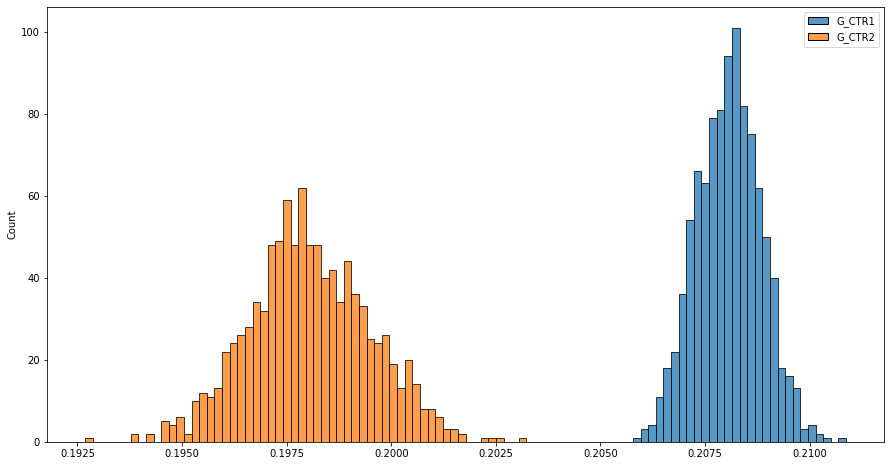

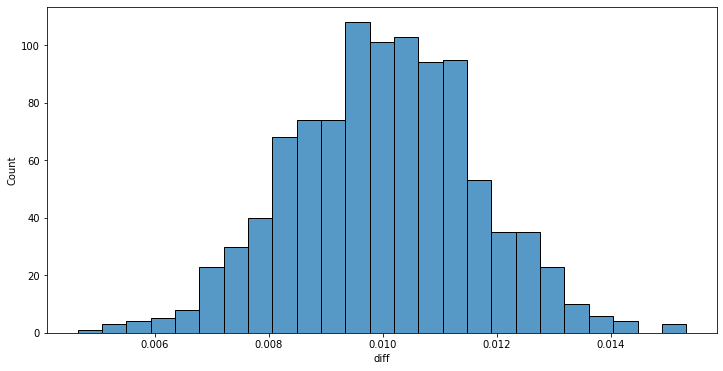

In [29]:
# Визуализируем полученные результаты.

plt.figure(figsize=(15, 8))
sns.histplot(data=[df_ctr.G_CTR1, df_ctr.G_CTR2], bins=100)
plt.show()
plt.figure(figsize=(12, 6))
sns.histplot(x=df_ctr['diff'])
plt.show()

В целом после визуального сравнения рассчитанных global CTR видно, что показатели не пересекаются и CTR в контрольной группы выше нежели в тестовой. Разница в нашем случае положительная, т.к. из CTR 1 группы вычитался CTR 2 группы.
Пуассоновский бутстреп подтвердил наше предположение о том, что новый алгорит не увеличил CTR в тестовой группе по сравнению с контрольной, а наоборот ухудшил данный показатель. 

Мысли по поводу, почему могло так произойти.
Сдесь следует отметить, что пользователи в тестовой выборке разбилась на две группы и у одной из них CTR был значительно выше, чем во второй. Поэтому следует проанализировать пользователей в тестовой группе, чтобы лучше понимать, почему так произошло и на основе анализа вносить корректировки в алгоритм подбора постов. Вероятней всего алгоритм не работает корректно на всех группах пользователей (к примеру по полу, территории, возрасту и тд.) поэтому пользователи в тестовой выборки и разделились.

После анализа полученных данных АВ теста, можно однозначно отказаться от раскатки нового алгоритма (по крайней мере в том виде, в котором он есть) на всех пользователей.